In [ ]:
# Mount on Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!pip install --upgrade texttable git+https://github.com/lorenzobasile/DeepRobust.git
!pip install advertorch

  Cloning https://github.com/lorenzobasile/DeepRobust.git to /tmp/pip-req-build-cf085xeh
  Running command git clone -q https://github.com/lorenzobasile/DeepRobust.git /tmp/pip-req-build-cf085xeh
     |████████████████████████████████| 204kB 8.9MB/s 
     |████████████████████████████████| 71kB 6.4MB/s 
  Created wheel for deeprobust: filename=deeprobust-0-cp36-none-any.whl size=142494 sha256=f105d34ee062e7e6321e378e097dceb5b4244ce57a8d73c5e4a00b2f370d06e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-pjc_0nq9/wheels/73/c5/ae/8043f3f08a70c4c2a4584449a4f97f415682a4f0371f8f3890
Successfully built deeprobust
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


     |████████████████████████████████| 5.7MB 5.7MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp36-none-any.whl size=5696220 sha256=8845f9aa76b11dc0cfe46ffc55e27d6c3765bfaa2a3bcf91236a19d24ef94c28
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch


In [ ]:
# Going to my directory

%cd /content/gdrive/My Drive/Colab Notebooks/projectsml

/content/gdrive/My Drive/Colab Notebooks/projectsml


In [ ]:
## LIBRARIES

## Usual python tools
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display

## Torch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Torchvision
import torchvision 

## DeepRobust
import deeprobust.image.netmodels.train_model as trainmodel
from deeprobust.image.attack.pgd import PGD
from deeprobust.image.attack.fgsm import FGSM
from deeprobust.image.defense.fast import Fast
from deeprobust.image.defense.YOPO import YOPOpgd
from deeprobust.image.attack.onepixel import Onepixel
from deeprobust.image.config import attack_params
import deeprobust.image.netmodels.CNN as MODEL
from torchvision import transforms, datasets
from deeprobust.image.defense.fgsmtraining import FGSMtraining 
from deeprobust.image.defense.pgdtraining import PGDtraining
from deeprobust.image.config import defense_params
from deeprobust.image.netmodels.CNN import Net

## Advertorch
from advertorch.attacks import SinglePixelAttack

## Pandas 
import pandas as pd

In [ ]:
## LOAD CLASSES AND BUILD DICTIONARY

signs = pd.read_table("classes.txt", header=None, names=['Belgium signs'])

dicts = {}
for i in range(0,62):
  dicts[i] = signs['Belgium signs'][i]

print(dicts)

{0: 'uneven road', 1: 'humps', 2: 'slippery road', 3: 'bend, to left', 4: 'bend, to right', 5: 'double bend, first to left', 6: 'double bend, first to right', 7: 'children', 8: 'bicycle crossing', 9: 'cattle', 10: 'road works', 11: 'traffic lights', 12: 'level crossing with barrier', 13: 'other danger', 14: 'road narrows', 15: 'road narrows on left', 16: 'road narrows on right', 17: 'crossroads', 18: 'crossroads with right-of-way from the right', 19: 'give way', 20: 'priority from opposite direction', 21: 'stop', 22: 'no entry', 23: 'no bicycles', 24: 'max weight', 25: 'no heavy load', 26: 'max width', 27: 'max height', 28: 'traffic not allowed', 29: 'no turn left', 30: 'no turn right', 31: 'no overtaking', 32: 'max speed', 33: 'pedestrian zone', 34: 'drive straight', 35: 'turn', 36: 'drive straight or turn right', 37: 'roundabout', 38: 'bicycles only', 39: 'bicycles and pedestrians', 40: 'no parking', 41: 'no stopping on the side ', 42: 'no parking', 43: 'no parking 16-31', 44: 'prior

In [ ]:
torch.manual_seed(torch.rand(1))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [ ]:
## SOME USEFUL FUNCTIONS

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, vmin=0, vmax=1)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    #plt.pause(0.001)  # pause a bit so that plots are updated
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
    return float(n_right) / tot

In [ ]:
## TRANSFORMATIONS

data_transforms = {'Training': torchvision.transforms.Compose([ torchvision.transforms.Resize((64,64)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ]),
                   'Testing': torchvision.transforms.Compose([ torchvision.transforms.Resize((64,64)),
                                                                torchvision.transforms.ToTensor(),
                                                                torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.3, 0.3, 0.3]) 
                                                              ])
                   }

In [ ]:
## LOADING DATA

# Location of data
data_dir = './data/'

# Load dataset
datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
# Create dataloaders (test and train)
dataloaders = {'Training': DataLoader(datasets['Training'], batch_size=64, shuffle=True),'Testing': DataLoader(datasets['Testing'], batch_size=64, shuffle=True)}

# Save sizes and classes
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Testing']}
class_names = datasets['Training'].classes

In [ ]:
## LOAD GOOGLENET

net=torchvision.models.googlenet(pretrained=True, progress=True)
net.fc=nn.Linear(net.fc.in_features,62)
net.to(device)
net.load_state_dict(torch.load("models/64_20e.h5"), strict=False)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


<All keys matched successfully>

In [ ]:
def _show_images(img, advimg, pred, advpred,probpre, probafter):
    
    perturb = advimg - img
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.3, 0.3, 0.3])

    plt.figure(figsize=(10, 8))

    plt.subplot(1, 3, 1)
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    m=nn.Softmax(0)
    plt.title("original image\n prediction: {}\n with probability: {}".format(dicts[pred],probpre))
    
    plt.subplot(1, 3, 2)
    perturb = perturb.numpy().transpose((1, 2, 0))
    perturb = std * perturb + mean
    perturb = np.clip(perturb, 0, 1)
    plt.imshow(perturb)
    plt.axis("off")
    plt.title("the perturbation")
    
    plt.subplot(1, 3, 3)
    advimg = advimg.numpy().transpose((1, 2, 0))
    advimg = std * advimg + mean
    advimg = np.clip(advimg, 0, 1)
    plt.imshow(advimg)
    plt.axis("off")
    plt.title("perturbed image\n prediction: {}\n with probability:{}".format(dicts[advpred],probafter))
    plt.show()

tensor(0.9993, grad_fn=<SelectBackward>)

In [ ]:
epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]

In [ ]:
%ls models/

'64_20e(1).h5'                pgd_64_5e_eps0.010000.h5
 64_20e.h5                    pgd_64_5e_eps0.030000.h5
 fgsm_64_20e_eps0.010000.h5  'pgd_64_5e_eps0.050000(1).h5'
 fgsm_64_20e_eps0.030000.h5   pgd_64_5e_eps0.050000.h5
 fgsm_64_20e_eps0.050000.h5   pgd_64_5e_eps0.100000.h5
 fgsm_64_20e_eps0.100000.h5   pgd_64_5e_eps0.150000.h5
 fgsm_64_20e_eps0.150000.h5   pgd_64_5e_eps0.200000.h5
 fgsm_64_20e_eps0.200000.h5   pgd_64_5e_eps0.300000.h5
 fgsm_64_20e_eps0.300000.h5   TherEnc_64_20e.h5
 fgsm_64_20e_eps0.h5


In [ ]:
### ADVERSARIAL ACCURACY OF GOOGLENET AFTER ADVERSARIAL TRAINING

net.eval()
adversarial_accuracies_after = []

# Evaluate model on adversarial attacks
for epsi in epsilons:
  print("attack epsilon=",epsi)
  for eps in epsilons:
    net.load_state_dict(torch.load('models/fgsm_64_20e_eps%f.h5'%eps), strict=False) 

    correct = 0
    batch_number = 0
    tot = len(dataloaders['Testing'].dataset)
    
    for data, target in dataloaders['Testing']:
    
      #Send the data and label to the device
      data, target = data.to('cuda'), target.to('cuda')
      batch_size = data.size()[0]

      ## Call PGD Attack
      adversary = FGSM(net, 'cuda')
      Adv_img = adversary.generate(data, target, epsilon = epsi)

      # Re-classify the perturbed image
      output = net(Adv_img)

      # Check for success
      final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability

      correct += torch.sum(target == final_pred)

    adversarial_accuracies_after.append(float(correct)/float(tot))
   
    print("defense Epsilon = {}: adversarial test Accuracy = {} / {} -> {:.2f}%".format(eps, correct, tot, float(correct)/float(tot)*100))

attack epsilon= 0.3
defense Epsilon = 0.3: adversarial test Accuracy = 2328 / 2520 -> 92.38%
defense Epsilon = 0.2: adversarial test Accuracy = 2347 / 2520 -> 93.13%
defense Epsilon = 0.15: adversarial test Accuracy = 2330 / 2520 -> 92.46%
defense Epsilon = 0.1: adversarial test Accuracy = 2371 / 2520 -> 94.09%
defense Epsilon = 0.05: adversarial test Accuracy = 2389 / 2520 -> 94.80%
defense Epsilon = 0.03: adversarial test Accuracy = 2366 / 2520 -> 93.89%
defense Epsilon = 0.01: adversarial test Accuracy = 2402 / 2520 -> 95.32%
attack epsilon= 0.2
defense Epsilon = 0.3: adversarial test Accuracy = 2344 / 2520 -> 93.02%
defense Epsilon = 0.2: adversarial test Accuracy = 2359 / 2520 -> 93.61%
defense Epsilon = 0.15: adversarial test Accuracy = 2372 / 2520 -> 94.13%
defense Epsilon = 0.1: adversarial test Accuracy = 2379 / 2520 -> 94.40%
defense Epsilon = 0.05: adversarial test Accuracy = 2392 / 2520 -> 94.92%
defense Epsilon = 0.03: adversarial test Accuracy = 2387 / 2520 -> 94.72%
defe

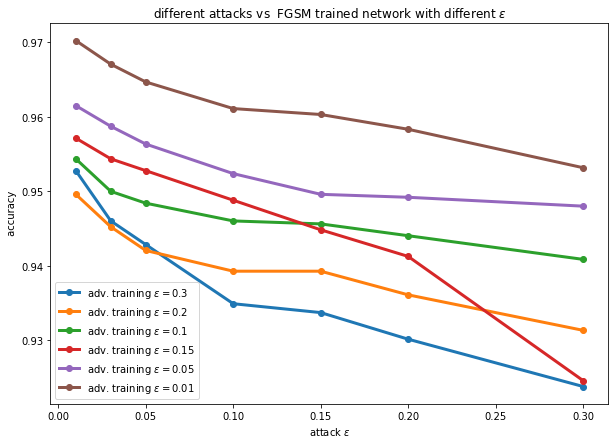

In [ ]:
plt.figure(figsize=(10, 7))
eps03=[]
eps02=[]
eps015=[]
eps01=[]
eps005=[]
eps003=[]
eps001=[]
for i in range(0,len(adversarial_accuracies_after),7):
  eps03.append(adversarial_accuracies_after[i])
  eps02.append(adversarial_accuracies_after[i+1])
  eps015.append(adversarial_accuracies_after[i+2])
  eps01.append(adversarial_accuracies_after[i+3])
  eps005.append(adversarial_accuracies_after[i+4])
  eps003.append(adversarial_accuracies_after[i+5])
  eps001.append(adversarial_accuracies_after[i+6])
plt.plot(epsilons, eps03, lw=3, label='adv. training $\epsilon =0.3$',marker='o')
plt.plot(epsilons, eps02, lw=3, label='adv. training $\epsilon =0.2$',marker='o')
plt.plot(epsilons, eps01, lw=3, label='adv. training $\epsilon =0.1$',marker='o')
plt.plot(epsilons, eps015, lw=3, label='adv. training $\epsilon=0.15$',marker='o')
plt.plot(epsilons, eps005, lw=3, label='adv. training $\epsilon=0.05$',marker='o')
plt.plot(epsilons, eps001, lw=3, label='adv. training $\epsilon=0.01$',marker='o')
plt.xlabel("attack $\epsilon$")
plt.ylabel(" accuracy")
plt.title("different attacks vs  FGSM trained network with different $\epsilon$")
plt.legend()

In [ ]:
eps001

NameError: ignored

In [ ]:


eps03=[]
eps02=[]
eps015=[]
eps01=[]
eps005=[]
eps003=[]
eps001=[]
for i in range(0,len(adversarial_accuracies_after),7):
  eps03.append(adversarial_accuracies_after[i])
  eps02.append(adversarial_accuracies_after[i+1])
  eps015.append(adversarial_accuracies_after[i+2])
  eps01.append(adversarial_accuracies_after[i+3])
  eps005.append(adversarial_accuracies_after[i+4])
  eps003.append(adversarial_accuracies_after[i+5])
  eps001.append(adversarial_accuracies_after[i+6])
eps03

[0.7186507936507937,
 0.7388888888888889,
 0.7654761904761904,
 0.8067460317460318,
 0.8738095238095238,
 0.9043650793650794,
 0.9273809523809524]

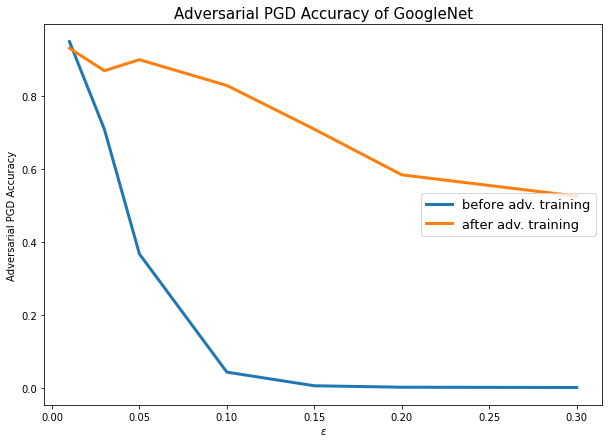

In [ ]:
## PLOT ACCURACIES BEFORE/AFTER ADVERSARIAL TRAINING

plt.figure(figsize=(10, 7))
epsilons = [0.3, 0.2, 0.15, 0.1, 0.05, 0.03, 0.01]

plt.plot(epsilons, adversarial_accuracies_before, lw=3, label='before adv. training')
plt.plot(epsilons, adversarial_accuracies_after, lw=3, label='after adv. training')
plt.title("Adversarial PGD Accuracy of GoogleNet", fontsize=15)
plt.xlabel("$\epsilon$", fontsize=10)
plt.ylabel("Adversarial PGD Accuracy", fontsize=10)
plt.legend(loc = 'center right', fontsize=13)
plt.savefig("plots/pgd_attack.png")

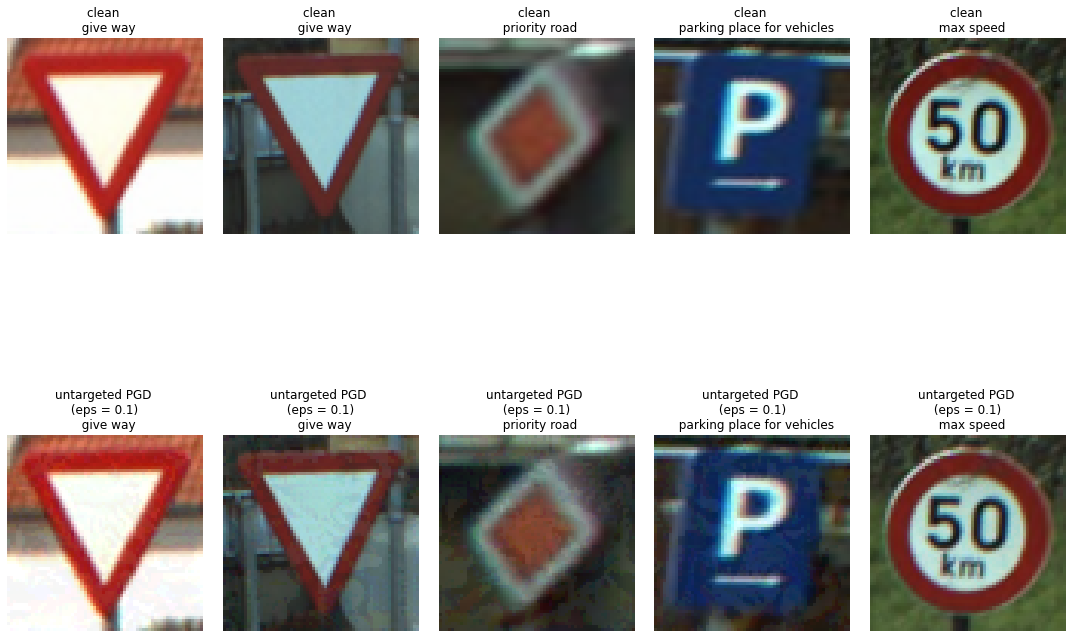

In [ ]:
## SHOW IMAGES AND PREDICTION OF THE NET ON ADV. ATTACKS (EPSILON=0.15)
## THE NET NOW HAS DONE ADV.TRAINING

net.load_state_dict(torch.load('models/pgd_64_5e_eps%f.h5'%epsilons[3]), strict=False)

adversary = PGD(net, 'cuda')
Adv_img = adversary.generate(x, y, epsilon = epsilons[3])

output_adv = net(Adv_img)
output_img = net(x)

pred=torch.argmax(output_img, dim=1)
advpred=torch.argmax(output_adv, dim=1)

plt.figure(figsize=(15,13))
batch_size = 5

for ii in range(5):
    plt.subplot(2, batch_size, ii + 1)
    imshow(x[ii].cpu().detach())
    plt.title("clean \n  {}".format(dicts[pred[ii].item()]))
    plt.subplot(2, batch_size, ii + 1 + batch_size)
    imshow(Adv_img[ii].cpu().detach())
    plt.title("untargeted PGD \n (eps = {}) \n  {}".format(0.1, dicts[advpred[ii].item()]))

plt.tight_layout()
plt.show()